In [ ]:
# imports
import cv2
import os
import numpy as np
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms.functional  import InterpolationMode
import torchvision
import torch
import torch
import torch.nn as nn
from torchsummary import summary
from statistics import mean
import PIL
import matplotlib.pyplot as plt
import numpy as np

# fill in details:

Student ID: 322710534

Student first name: Meytal

Student last name: Keren

**Project Scope**:
Build a CNN classifier from scratch, on your own data that works on your live stream.

1. Acquire dataset (Train and Validation):

   Grab frames from your camera for 3 classes (your own selection).
   The amount of data to collect, is decided by you to reach good live performance.
2. Define pytorch dataset and data loader:
Define train and validation datasets and dataloader using **dset.ImageFolder(...)** with proper transforms. Also plot a few training and validation batches.

3. Define your CNN network (**must use pytorch, and build your own network**)
4. Train your network:

   Train the network, print training accuracy and loss per epoch, and also for the validation. **Save the best model to disk, and download it**.
   Plot a few validation batches, with their labels and their predictions.

5. Live model inference:
Connect to your laptop camera, grab frame by frame, and plot on the image the classification of the frame. If you did everything right, your model should work quite well.

**items to submit for this assignment**:
1. Students that will demonstrate their project on live stream (and it really works..) until the deadline, will not have to submit any item
2. Otherwise submit the following:
   - This notebook, filled with all the **#place your code here** areas
   - your model saved for inference
   - 3 batches on the validation, with labels and predictions
   - 3 Minutes video file, demonstrating the student performing the 3 classes, with the model classification per frame plotted in the video


#Data set collection#

In [ ]:
# Create Directories
dataset_dir = './dataset/'
num_classes = 3

# Place your code here (1): describe your classes
text_for_classes = ['sunglasses ','hat','Nothing']

num_of_images_to_save = 1000

os.mkdir(dataset_dir)
os.mkdir(dataset_dir + 'train')
os.mkdir(dataset_dir + 'test')

# Create directories
[os.mkdir(dataset_dir + 'train/' + str(i)) for i in range(num_classes)]
[os.mkdir(dataset_dir + 'test/' + str(i)) for i in range(num_classes)]


[None, None, None]

In [ ]:
# Place your code here (2): define your own video width and height
width = 224
height = 224

# functions for capturing webcam
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame(width, height) {
      if (!shutdown) {
         window.requestAnimationFrame(function() {
            onAnimationFrame(width, height);
    });
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, width, height);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom(width, height) {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = width; //video.videoWidth;
      captureCanvas.height = height; //video.videoHeight;
      window.requestAnimationFrame(function() {
      onAnimationFrame(width, height);
    });
      return stream;
    }

 async function stop_sream() {
        shutdown = true;
        removeDom();

        return '';
 }

    async function stream_frame(label, imgData, width, height) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom(width, height);

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox, width, videoHeight):
  data = eval_js('stream_frame("{}", "{}", "{}", "{}")'.format(label, bbox, width, height))
  return data

def video_stream_stop():
  eval_js('stop_sream("{}")')


In [ ]:
from datetime import datetime
def grab_dataset(save_path):
    for i in range(num_classes):
      input('Press Enter to capture class ' + text_for_classes[i] + '...')
      # start streaming video from webcam
      frame_num = 0
      saved_frames = 0
      video_stream()
      # label for video
      label_html = 'Capturing...'
      # initialze bounding box to empty
      bbox = ''
      count = 0
      file_names = []
      frames = []
      while True:
          frame_num = frame_num + 1
          js_reply = video_frame(label_html, bbox, width, height)
          if not js_reply:
              break

          # convert JS response to OpenCV Image
          frame = js_to_image(js_reply["img"])

          # Save Frames
          label_html = 'Saving...' + str(saved_frames)
          file_name = save_path + str(i) + '/' + datetime.now().strftime("%m_%d_%Y_%H_%M_%S_") + str(frame_num) + '.jpg'
          file_names.append(file_name)
          frames.append(frame)
            #cv2.imwrite(file_name, frame)
          saved_frames = saved_frames + 1

          if saved_frames == num_of_images_to_save:
            video_stream_stop()
            print ('saving to disk...')
            for i,f in enumerate(file_names):
              cv2.imwrite(f, frames[i])
            break



In [ ]:
# grab your dataset --> this should be an ongoing process, till you get good performance

grab_dataset(dataset_dir + '/train/')
grab_dataset(dataset_dir + '/test/')

Press Enter to capture class sunglasses ...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class hat...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Nothing...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class sunglasses ...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class hat...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Nothing...


<IPython.core.display.Javascript object>

saving to disk...


In [ ]:
# download dataset (so can merge with the dataset you already collected, and later upload it to colab)
from google.colab import files
!zip -r ./ds.zip ./dataset/
files.download('./ds.zip')

Streaming output truncated to the last 5000 lines.
  adding: dataset/train/0/04_19_2025_12_22_30_22.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_24_18_494.jpg (deflated 4%)
  adding: dataset/train/0/04_19_2025_12_22_27_7.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_25_28_800.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_23_03_164.jpg (deflated 4%)
  adding: dataset/train/0/04_19_2025_12_22_28_14.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_22_25_2.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_24_22_513.jpg (deflated 4%)
  adding: dataset/train/0/04_19_2025_12_23_39_323.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_24_31_551.jpg (deflated 4%)
  adding: dataset/train/0/04_19_2025_12_24_06_441.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_23_03_166.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_25_25_788.jpg (deflated 5%)
  adding: dataset/train/0/04_19_2025_12_23_57_402.jpg (deflated 5%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# dataset upload (Now you have a dataset and need to upload it for training)

# download dataset
from google.colab import files

files.upload()

KeyboardInterrupt: 

In [ ]:
#extract your dataset zip file
# !unzip /content/ds.zip
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ds.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/1/04_08_2025_09_49_14_177.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_14_178.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_14_179.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_14_180.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_14_181.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_15_182.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_15_183.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_15_184.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_15_185.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_15_186.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_15_187.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_16_188.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_16_189.jpg  
  inflating: /content/dataset/train/1/04_08_2025_09_49_16_190.jpg

#Dataset definition#

Training set size: 8775
Validation set size: 2925


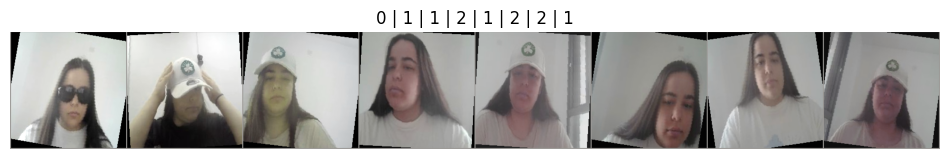

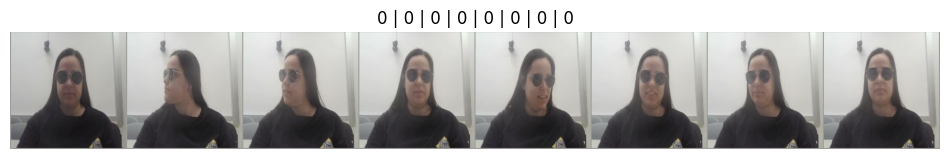

Batch shape: torch.Size([8, 3, 224, 224])
Min pixel value: -3.5786828994750977
Max pixel value: 2.295264959335327
Average pixel value: -0.17980831861495972


In [ ]:
# Place your code here (3):
# define:
# Batch size
batch_size = 32

# Normalize function
def normalize(dataset,loader):
  mean = 0.
  std = 0.
  total_images = 0

  for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)
    mean += images.mean(dim=[0, 2]) * batch_samples
    std += images.std(dim=[0, 2]) * batch_samples
    total_images += batch_samples

  mean /= total_images
  std /= total_images
  return mean, std

def unnormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return img_tensor * std + mean

# Train and validation transforms using transforms.Compose
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

temp_train_dataset = dset.ImageFolder(root=dataset_dir + '/train', transform=temp_transform)
temp_train_loader = torch.utils.data.DataLoader(temp_train_dataset, batch_size=batch_size, shuffle=False)

mean, std = normalize(temp_train_dataset, temp_train_loader)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize to 224x224
    transforms.RandomHorizontalFlip(),     # Horizontal Flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Random Crop and Scale
    transforms.RandomRotation(10),         # Random Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color Jitter
    transforms.ToTensor(),                 # Convert images to tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize
])

validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize to 224x224
    transforms.ToTensor(),                 # Convert images to tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize
])

# Train and validation datasets using dset.ImageFolder
train_dataset = dset.ImageFolder(root=dataset_dir + '/train', transform=train_transform)
validation_dataset = dset.ImageFolder(root=dataset_dir + '/test', transform=validation_transform)

# Train and validation dataloaders using torch.utils.data.DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


# print the length of your train and validation sets
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(validation_dataset)}')

# plot a few training batches with their labels (make sure you can recognize the classes after the transforms , example code below)
def imshow(img, labels=None, classes=None, mean=None, std=None):
    img = img.clone()

    if mean is not None and std is not None:
        img = unnormalize(img, mean, std)

    img = img.clamp(0, 1)
    npimg = img.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

    if labels is not None and classes is not None:
        label_names = [classes[label] for label in labels]
        plt.title(' | '.join(label_names[:8]), fontsize=12)

    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images[:8], labels[:8]
classes = train_dataset.classes
imshow(torchvision.utils.make_grid(images), labels, classes, mean=mean.tolist(), std=std.tolist())

# plot a few validation batches with their labels
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images, labels = images[:8], labels[:8]
classes = validation_dataset.classes
imshow(torchvision.utils.make_grid(images), labels, classes, mean=mean.tolist(), std=std.tolist())

# print the shape of a single batch of images, and their min, max, and average pixel value
print(f'Batch shape: {images.shape}')
print(f'Min pixel value: {images.min()}')
print(f'Max pixel value: {images.max()}')
print(f'Average pixel value: {images.mean()}')

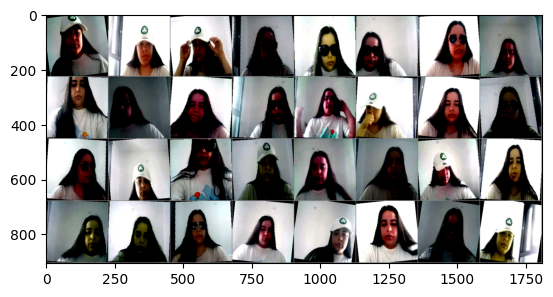

In [ ]:

## functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

#Training#

In [ ]:
# Place your code here (4): define your CNN

class liveClassifier(nn.Module):
  def __init__(self):
    super(liveClassifier, self).__init__()
    # # Place your code here (4.1): define your model

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 28 * 28, 512)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, 3)

  def forward(self, x):
    # Place your code here (4.2): define forward pass
    x = self.pool(torch.nn.functional.relu(self.bn1(self.conv1(x))))
    x = self.pool(torch.nn.functional.relu(self.bn2(self.conv2(x))))
    x = self.pool(torch.nn.functional.relu(self.bn3(self.conv3(x))))
    x = x.flatten(1)
    x = torch.nn.functional.relu(self.fc1(x))
    x = self.dropout(x)
    logits = self.fc2(x)
    return logits


In [ ]:
# Create an instance of your model, and print its summary

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Xavier
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Initialize model and apply Xavier initialization
model = liveClassifier().to(device)
model.apply(init_weights)

# EarlyStopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

# Place your code here (5): print summary using summary(model,(aa, bb, bb ))
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 3]           1,539
Total params: 51,475,971
Trainable params: 51,475,971
Non-trainable params: 0
-------------------------

In [ ]:
# Place your code here (6): Define your loss criterion, and optimizer (e.g criterion = nn.CrossEntropyLoss(), optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum = 0.9)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # lr=0.01 lr=0.002
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/30]
Train Loss: 6.3251, Train Accuracy: 53.14%
Validation Loss: 0.5739, Validation Accuracy: 66.09%
Model improved and saved at epoch 1
Epoch [2/30]
Train Loss: 0.6913, Train Accuracy: 61.68%
Validation Loss: 0.4791, Validation Accuracy: 70.97%
Model improved and saved at epoch 2
Epoch [3/30]
Train Loss: 0.5851, Train Accuracy: 70.55%
Validation Loss: 0.2024, Validation Accuracy: 93.85%
Model improved and saved at epoch 3
Epoch [4/30]
Train Loss: 0.6026, Train Accuracy: 72.49%
Validation Loss: 0.3183, Validation Accuracy: 85.50%
EarlyStopping counter: 1 out of 5
Epoch [5/30]
Train Loss: 0.5378, Train Accuracy: 76.89%
Validation Loss: 0.9939, Validation Accuracy: 71.83%
EarlyStopping counter: 2 out of 5
Epoch [6/30]
Train Loss: 0.4997, Train Accuracy: 78.58%
Validation Loss: 0.3519, Validation Accuracy: 82.19%
EarlyStopping counter: 3 out of 5
Epoch [7/30]
Train Loss: 0.4064, Train Accuracy: 82.19%
Validation Loss: 0.1089, Validation Accuracy: 97.44%
Model improved and saved at

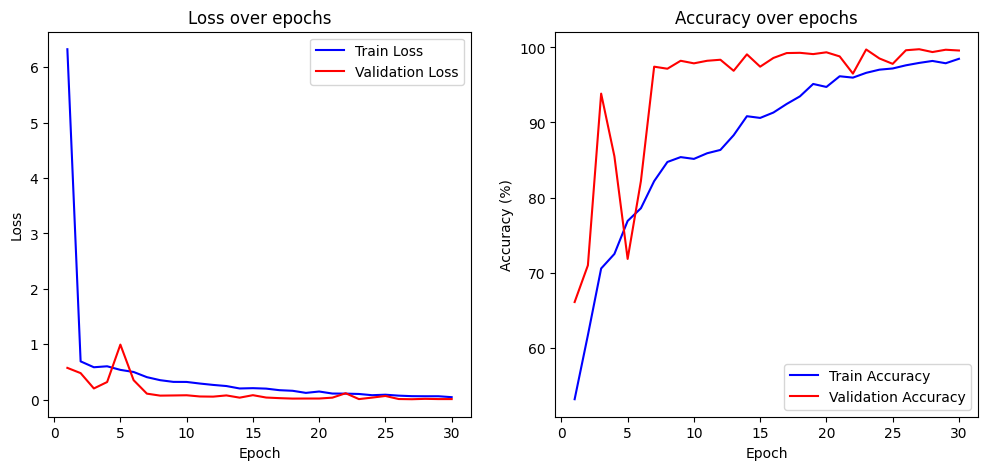

In [ ]:
# Place your code here (7): train loop

num_epochs = 30

best_val_loss = float('inf')
best_val_accuracy = 0.0
best_model = None

early_stopping = EarlyStopping(patience=5, delta=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_epochs = []
actual_epochs = 0

model.to(device)
for epoch in range(num_epochs):
    #Place your code here (7.1): Train (don't forget to call model.train())
    model.train()
    train_batch_losses = []
    correct_train = 0
    total_train = 0

    for batch, labels in train_loader:
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        train_batch_losses.append(loss.detach().cpu())
        _, predicted = torch.max(y_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = torch.mean(torch.stack(train_batch_losses)).item()
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #Place your code here (7.2): Evaluate (don't forget to call model.eval())
    model.eval()
    val_batch_losses = []
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch, labels in validation_loader:
            batch, labels = batch.to(device), labels.to(device)
            y_pred = model(batch)
            loss = criterion(y_pred, labels)
            val_batch_losses.append(loss.detach().cpu())
            _, predicted = torch.max(y_pred, dim=1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = torch.mean(torch.stack(val_batch_losses)).item()
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies_epochs.append(val_accuracy)

    #Place your code here (7.3): Print Train loss and accuracy, print Eval loss and accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    #Place your code here (7.4): If model has improved, save it to disk using torch.save(model.state_dict(), dataset_dir + 'savedmodel')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_model = model.state_dict()
        torch.save(model.state_dict(), dataset_dir + 'savedmodel.pth')
        print(f"Model improved and saved at epoch {epoch+1}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    actual_epochs += 1

#Place your code here (7.5): print your best model performance (evaluation loss and accuracy)
print("\nBest Model Performance:")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

#Place your code here (7.6): plot loss and accuracy curves (Train + evaluation)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, actual_epochs + 1), train_losses[:actual_epochs], label="Train Loss", color='blue')
plt.plot(range(1, actual_epochs + 1), val_losses[:actual_epochs], label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over epochs")

plt.subplot(1, 2, 2)
plt.plot(range(1, actual_epochs + 1), train_accuracies[:actual_epochs], label="Train Accuracy", color='blue')
plt.plot(range(1, actual_epochs + 1), val_accuracies_epochs[:actual_epochs], label="Validation Accuracy", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy over epochs")

plt.show()

In [ ]:
# download model
files.download(dataset_dir +'savedmodel.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# upload model
from google.colab import files

files.upload()

Saving savedmodel (2).pth to savedmodel (2).pth
Buffered data was truncated after reaching the output size limit.

In [ ]:
# load model

model = liveClassifier()
model.load_state_dict(torch.load(dataset_dir +'savedmodel.pth'))
model.to(device)
model.eval()

liveClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

## Inference

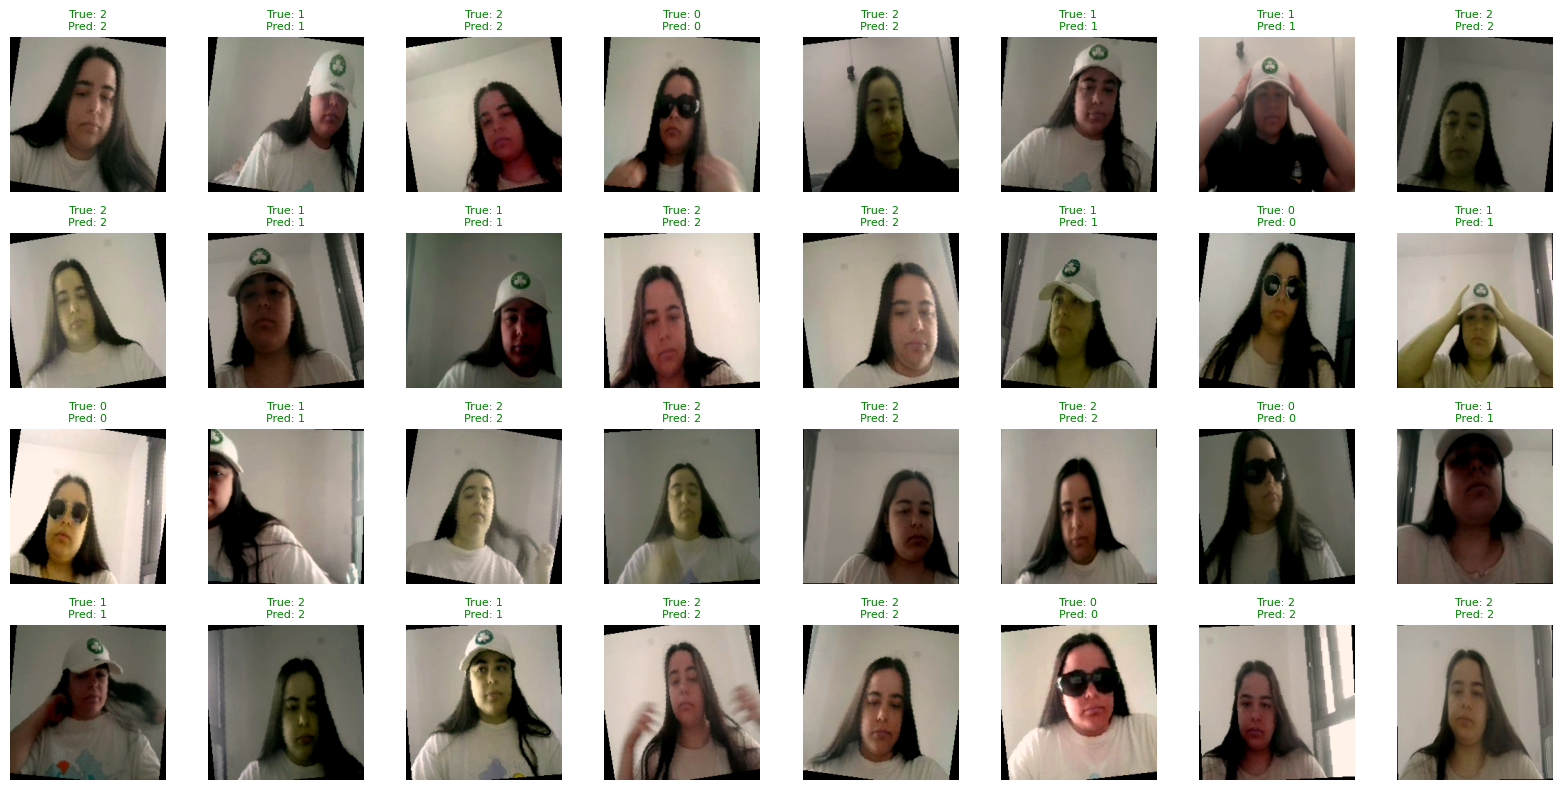

In [ ]:
# Place your code here (8): Plot few batches with their labels and predictions
import math
def denormalize(image, mean, std):
    image = image.copy()
    image *= std
    image += mean
    return np.clip(image, 0, 1)

def plot_batches_with_labels_and_predictions(model, dataloader, device, num_batches=1, images_per_row=8):
    model.eval()
    dataiter = iter(dataloader)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for _ in range(num_batches):
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

        images_np = images.cpu().numpy().transpose((0, 2, 3, 1))
        labels = labels.cpu()
        predicted = predicted.cpu()

        num_images = len(images_np)
        rows = math.ceil(num_images / images_per_row)
        fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 2, rows * 2))

        if rows == 1:
            axes = np.expand_dims(axes, 0)

        for idx in range(num_images):
            row = idx // images_per_row
            col = idx % images_per_row
            ax = axes[row][col]

            img = denormalize(images_np[idx], mean, std)
            ax.imshow(img)
            is_correct = predicted[idx].item() == labels[idx].item()
            title_color = 'green' if is_correct else 'red'
            ax.set_title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}",
                         fontsize=8, color=title_color)
            ax.axis('off')

        for idx in range(num_images, rows * images_per_row):
            row = idx // images_per_row
            col = idx % images_per_row
            axes[row][col].axis('off')

        plt.tight_layout()
        plt.show()

plot_batches_with_labels_and_predictions(model, train_loader, device,1)

In [ ]:
# Place your code here (9): Run live inference, plot classification on the video using bbox_array = cv2.putText(img=bbox_array, text=pred_class_name, org=(x, y), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(200, 200, 200, 255),thickness=1)
# Also save frames with classification plotted on it to video file (download it for submition)

import ipywidgets as widgets
from IPython.display import display, Javascript, clear_output
from google.colab import output
import cv2
import numpy as np
from PIL import Image
import io
from base64 import b64decode


text_for_classes = {0: 'sunglasses', 1: 'hat', 2: 'Nothing'}

output_widget = widgets.Output()
display(output_widget)

def capture_frame_js_auto(quality=0.8):
    js_code = f"""
    async function captureFrameAuto(quality) {{
        const div = document.createElement('div');
        const video = document.createElement('video');
        const stopButton = document.createElement('button');
        stopButton.textContent = 'When finished, click here or on the video to stop this demo';
        stopButton.style.marginTop = '10px';

        video.style.display = 'block';
        div.appendChild(video);
        div.appendChild(stopButton);
        document.body.appendChild(div);

        const stream = await navigator.mediaDevices.getUserMedia({{ video: true }});
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        let stop = false;
        stopButton.onclick = () => stop = true;

        while (!stop) {{
            await new Promise(resolve => setTimeout(resolve, 1000));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const ctx = canvas.getContext('2d');
            ctx.drawImage(video, 0, 0);
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            await google.colab.kernel.invokeFunction('notebook.process_frame_auto', [dataUrl], {{}});
        }}

        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return 'stopped';
    }}
    captureFrameAuto({quality});
    """
    display(Javascript(js_code))

def decode_and_process_image(data_url):
    image_bytes = b64decode(data_url.split(',')[1])
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    img_array = np.array(image)
    return img_array

def classify_image(img_array):
    if model is None or validation_transform is None:
        return "Error", 0.0
    img_pil = Image.fromarray(img_array)
    input_tensor = validation_transform(img_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        confidence, predicted = torch.max(probs, 0)
        pred_class = predicted.item()
        pred_name = text_for_classes.get(pred_class, "Unknown")
        return pred_name, confidence.item()

def display_prediction(prediction_text, img_array):
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    annotated_image = cv2.putText(
        img=img_bgr,
        text=prediction_text,
        org=(10, 30),
        fontFace=cv2.FONT_HERSHEY_TRIPLEX,
        fontScale=0.6,
        color=(0, 0, 0),
        thickness=1
    )
    img_display = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    with output_widget:
        output_widget.clear_output(wait=True)
        display(Image.fromarray(img_display))

def process_frame_auto(data_url):
    img_array = decode_and_process_image(data_url)
    pred_name, confidence = classify_image(img_array)

    prediction_text = f'{pred_name.capitalize()} (Confidence: {confidence:.2f})'

    display_prediction(prediction_text, img_array)

output.register_callback('notebook.process_frame_auto', process_frame_auto)

capture_frame_js_auto()

Output()

<IPython.core.display.Javascript object>

**I hope you had fun (-:**

Good luck!

Lahav